# Simple XY plot for Time evolution of mean squares

This notebook generates time evolution plot of mean squre data averaged over spherical shell. The imput date is one of these files.
1. Volume mean square and average
    * [vol_ave_prefix].dat
    * [vol_pwr_prefix]_s.dat
    * [vol_pwr_prefix]_m0.dat
    * [typical scale prefix].dat

In this example, [vol_pwr_prefix]_s.dat is used.

## Initial setup

In [1]:
import sys
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from ctypes import *

Move current directory to directory with data to be averaged

In [2]:
%cd ./

/Volumes/Sources/matsui/Kemorin_MHD/MHD/pythons


Check if shared libraly to load is there

In [3]:
%ls -l "libcalypso_to_pythons.so"

-rwxr-xr-x  1 matsui  staff  199589 Jun 19 09:54 libcalypso_to_pythons.so*


Load dynamic library to run the program

In [4]:
libname = "libcalypso_to_pythons.so"
flib = cdll.LoadLibrary(libname)

## Go to data directory

Move current directory to directory with data to be averaged

In [5]:
cd ~/Desktop/sph_shell_456/monitor

/Users/matsui/Desktop/sph_shell_456/monitor


Check if data file to be averaged is there

In [6]:
ls -l

total 1764120
-rw-r--r--  1 matsui  staff          0 Jun  8 19:40  Nusselt.dat
-rw-rw-r--  1 matsui  staff     602115 May  9 02:30 Nusselt.dat
-rw-r--r--@ 1 matsui  staff        970 Jun  9 09:38 control_sph_time_average
-rw-r--r--  1 matsui  staff        155 Jun  8 19:51 control_sph_time_average~
-rw-rw-r--  1 matsui  staff     441092 May  9 02:30 dipolarity.dat
-rw-rw-r--  1 matsui  staff     819114 May  9 02:30 gauss_coefs_Re.dat
-rw-rw-r--  1 matsui  staff    2849572 May  9 02:30 sph_ave_volume.dat
-rw-rw-r--  1 matsui  staff  311136492 May  9 02:30 sph_pwr_layer_l.dat
-rw-rw-r--  1 matsui  staff  311136500 May  9 02:30 sph_pwr_layer_lm.dat
-rw-rw-r--  1 matsui  staff  311136491 May  9 02:30 sph_pwr_layer_m.dat
-rw-rw-r--  1 matsui  staff    3129484 May  9 02:30 sph_pwr_layer_m0.dat
-rw-rw-r--  1 matsui  staff    3129484 May  9 02:30 sph_pwr_layer_s.dat
-rw-rw-r--  1 matsui  staff  284928582 May  9 02:30 sph_pwr_volume_l.dat
-rw-rw-r--  1 matsui  staff  284928590 May  9 02:30 sph_pw

## Set file prefix to read and check the data entities
The file name is defined by [file_name]. The beginning part of the data file [file_name] is read and listed field or component names to be stored.

In [7]:
file_name = "sph_pwr_volume_s.dat"

# Load time average and standard deviation
flib.open_init_volume_mean_file_f.restype = c_void_p
flib.open_init_volume_mean_file_f.argtypes = [c_char_p]

flib.open_init_volume_mean_file_f(file_name.encode())

 Number of components:           16
 K_ene_pol
 K_ene_tor
 K_ene
 temperature
 pressure
 vorticity_pol
 vorticity_tor
 vorticity
 M_ene_pol
 M_ene_tor


19

 M_ene
 current_density_pol
 current_density_tor
 current_density
 buoyancy_flux
 Lorentz_work


## Select component names to be plotted
A list of component names are defined in 'field_name'. 
Time and data to be plotted are loaded into array 'time' and 'series', respectively.

In [8]:
# Set component name to be plotted
field_name = ["M_ene_pol", "M_ene_tor", "M_ene"]



n_comp = len(field_name)
i_comp = np.zeros((n_comp), dtype=np.int32)

# Find compoenent address to plot
flib.find_monitor_field_address_f.restype = c_int
flib.find_monitor_field_address_f.argtypes = [c_char_p]

icou = 0
for each_field in field_name:
    i_comp[icou] = flib.find_monitor_field_address_f(each_field.encode())
    print(icou, each_field, i_comp[icou])
    icou = icou + 1

# Read time series data to read
i_step_in = np.zeros((1),dtype=np.int32)
time_in = np.zeros((1),dtype=np.float64)
series_in = np.zeros((n_comp),dtype=np.float64)

i_step = np.zeros((0),dtype=np.int32)
time =   np.zeros((0),dtype=np.float64)
series = np.zeros((0),dtype=np.float64)

# Find compoenent address to plot
flib.load_one_volume_mean_item_f.restype = c_int
flib.load_one_volume_mean_item_f.argtypes = [c_int, np.ctypeslib.ndpointer(dtype=np.int32), 
                                            np.ctypeslib.ndpointer(dtype=np.int32), 
                                            np.ctypeslib.ndpointer(dtype=np.float64),
                                            np.ctypeslib.ndpointer(dtype=np.float64)]

#  Load time series to the end
while True:
    iflag = flib.load_one_volume_mean_item_f(n_comp, i_comp, i_step_in, time_in, series_in)
    if iflag > 0:
        print('!!Finish reading!!')
        break
    i_step = np.append(i_step,i_step_in)
    time =   np.append(time,  time_in)
    series = np.append(series, series_in)

#  Close data file
flib.finalize_sph_series_file_f()

0 M_ene_pol 9
1 M_ene_tor 10
2 M_ene 11
!!Finish reading!!


1

## Make a time evolution plot
The each time series data are expanded into each_series, and plotted into the line plot.
Please upgreade to more beautiful plot by yourself.

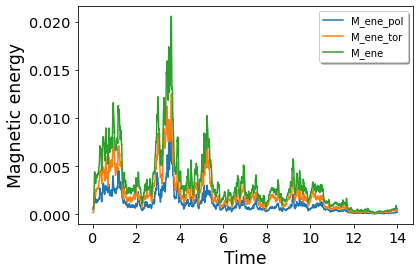

In [15]:
# Set work array to plot
n_series = len(time)
icou = 0
each_series = np.zeros((n_series),dtype=np.float64)

# Plot each component
for icou in range(n_comp):
    for i in range(n_series):
        each_series[i] = series[icou + i*n_comp]
    plt.plot(time, each_series, label=field_name[icou])

# Set graph configurations
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.xlabel('Time', fontsize='xx-large')
plt.ylabel('Magnetic energy', fontsize='xx-large')
legend = plt.legend(loc='upper right', shadow=True, fontsize='medium')

# plt.savefig("Emag.pdf")
plt.show()

<Figure size 432x288 with 0 Axes>